# Trial counts and corresponding tracks

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import pickle

In [2]:
from pp_utils.core import generate_data_path_dict
from pp_utils.file_handling import df_main_loader

## Set paths and load main info df

In [3]:
data_path = generate_data_path_dict(Path("../data_processed/"))
raw_path = Path("../data_raw/")

### Data and figure path

In [4]:
output_path = data_path["main"] / "data_summary"
tp_path = output_path / "trial_processor_object"

In [5]:
fig_path = Path("../figs")
if not fig_path.exists():
    fig_path.mkdir()

### Load main dataframe

In [6]:
df_main = df_main_loader(
    folder=data_path["info_csv"], filename="main_info_append_09.csv",
)

### Load full tracks

In [7]:
# full tracks for usable trials
with open(output_path / "track_all.pickle", "rb") as filein:
    df_track_all = pickle.load(filein)

## Correct/error rate

The error rates are calculated using all executed trials.

### Spheroid AR=1.3

In [8]:
print(
    f'{len(df_main[(df_main["SPHEROID"]=="M") & (df_main["CHOICE"]==0)])} '
    'incorrect trials out of '
    f'a total of {len(df_main[df_main["SPHEROID"]=="M"])} trials'
)

18 incorrect trials out of a total of 146 trials


In [9]:
M_error_rate = (
    len(df_main[(df_main["SPHEROID"]=="M") & (df_main["CHOICE"]==0)])
    / len(df_main[df_main["SPHEROID"]=="M"])
)

In [10]:
print(f'Error rate: {M_error_rate*100:.2f}%\nCorrect rate: {(1-M_error_rate)*100:.2f}%')

Error rate: 12.33%
Correct rate: 87.67%


### S spheroid

In [11]:
print(
    f'{len(df_main[(df_main["SPHEROID"]=="S") & (df_main["CHOICE"]==0)])} '
    'incorrect trials out of '
    f'a total of {len(df_main[df_main["SPHEROID"]=="S"])} trials'
)

12 incorrect trials out of a total of 33 trials


In [12]:
S_error_rate = (
    len(df_main[(df_main["SPHEROID"]=="S") & (df_main["CHOICE"]==0)])
    / len(df_main[df_main["SPHEROID"]=="S"])
)

In [13]:
print(f'Error rate: {S_error_rate*100:.2f}%\nCorrect rate: {(1-S_error_rate)*100:.2f}%')

Error rate: 36.36%
Correct rate: 63.64%


In [14]:
TARGET_ANGLE_STR_TC = ['TC1', 'TC2', 'TC3', 'TC4']
TARGET_ANGLE_STR_CT = ['CT1', 'CT2', 'CT3', 'CT4']
TARGET_ANGLE_STR = TARGET_ANGLE_STR_TC + TARGET_ANGLE_STR_CT

In [15]:
TARGET_ANGLE_STR_NEW = [
    "R+/0", "R+/45", "R+/90", "R+/145",
    "L+/0", "L+/45", "L+/90", "L+/145",
]

## Error rate and count for all AR=1.3 position-angle combinations

In [16]:
TARGET_ANGLE_STR

['TC1', 'TC2', 'TC3', 'TC4', 'CT1', 'CT2', 'CT3', 'CT4']

In [17]:
for tca in TARGET_ANGLE_STR:
    val_choice = df_main.loc[
        (df_main["TARGET_ANGLE"]==tca) & (df_main["SPHEROID"]=="M")
    ]["CHOICE"]
    print(f"---- {tca} -----------")
    print(f"count: {val_choice[val_choice==1].size} out of {val_choice.size}")
    print(f"perctage: {val_choice[val_choice==1].size / val_choice.size *100:2.2f}%")


---- TC1 -----------
count: 18 out of 18
perctage: 100.00%
---- TC2 -----------
count: 18 out of 18
perctage: 100.00%
---- TC3 -----------
count: 14 out of 18
perctage: 77.78%
---- TC4 -----------
count: 16 out of 18
perctage: 88.89%
---- CT1 -----------
count: 16 out of 19
perctage: 84.21%
---- CT2 -----------
count: 15 out of 19
perctage: 78.95%
---- CT3 -----------
count: 13 out of 18
perctage: 72.22%
---- CT4 -----------
count: 18 out of 18
perctage: 100.00%


## Find all usable trials

Usable trials should contain:
- `df_main['TRIAL_TO_INCLUDE'] = 'Y'` (deemed unusable due to various data collection issues)
- `TrialProcessor.trial_usable = True` (has usable data from all systems)

In [18]:
tp_data_usable = []
for trial_idx in df_main.index:
    # Load TrialProcessor object
    tp_obj_fname = tp_path / f"trial_{trial_idx:03d}.pickle"
    with open(tp_obj_fname, "rb") as filein:
        tp = pickle.load(filein)
        
    # Check if tp usable
    tp_data_usable.append(tp.trial_usable)

In [19]:
df_main["tp_data_usable"] = tp_data_usable

In [20]:
df_main["trial_usable_combine"] = df_main.apply(
    lambda x: (x["TRIAL_TO_INCLUDE"] == "Y") and x["tp_data_usable"], axis=1
)

Check the difference between the 2 criteria:

In [21]:
c1 = set(df_main[df_main["TRIAL_TO_INCLUDE"] == "Y"].index)

In [22]:
c2 = set(df_main[df_main["tp_data_usable"]].index)

In [23]:
c1.difference(c2)

set()

In [24]:
c2.difference(c1)

{9, 10, 13, 46, 152, 209, 210}

In [25]:
# Check trials that are in the difference set
for trial_idx in c2.difference(c1):
    print(df_main.iloc[trial_idx]["fname_prefix"], df_main.iloc[trial_idx]["SPHEROID"])

20190625_s2_t2 L
20190625_s2_t3 L
20190625_s2_t6 L
20190626_s3_t1 L
20190703_s3_t6 M
20190703_s3_t7 M
20190702_s1_t1 M


## Plot all executed + usable trials

In [26]:
# Bar color - hatch pattern
correct_usable = [np.ones(3)*220/255, ""]
correct_discard = [np.ones(3)*220/255, ".."]
incorrect_usable = [np.ones(3)*150/255, ""]
incorrect_discard = ["k", ""]

In [27]:
# Bar stacking sequence
color_seq = [incorrect_usable[0], incorrect_discard[0], correct_usable[0], correct_discard[0]]
hatch_seq = [incorrect_usable[1], incorrect_discard[1], correct_usable[1], correct_discard[1]]
barwidth=0.6

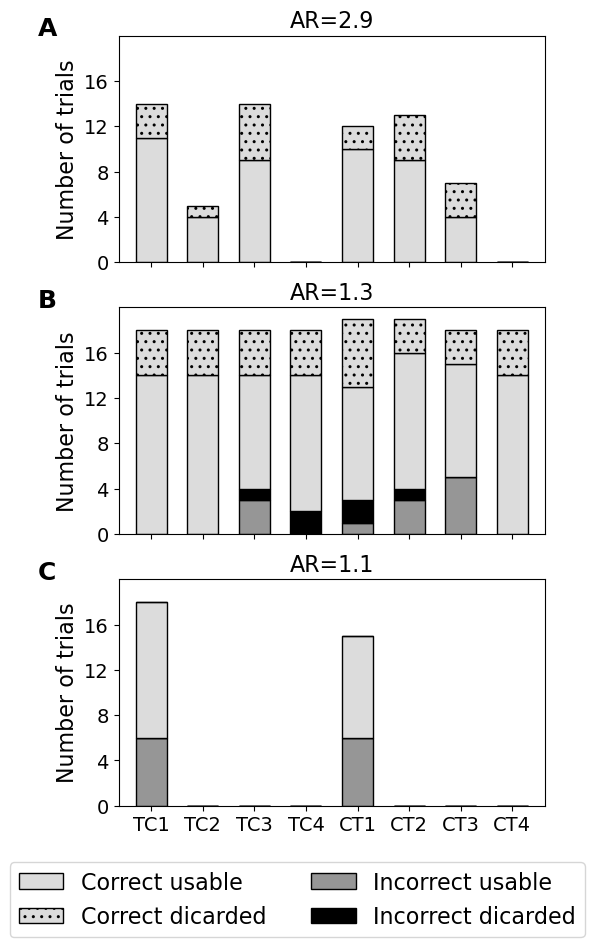

In [28]:
fig, ax = plt.subplots(3, 1, figsize=(5.5,10), facecolor="w", sharex=True)

plt.subplots_adjust(hspace=0.2)

for axx, sph_str, title_str, panel in zip(
    ax, ["L", "M", "S"], ["AR=2.9", "AR=1.3", "AR=1.1"], ["A", "B", "C"]
):
    for seq, tca in enumerate(TARGET_ANGLE_STR):
        # Tally trials
        s_executed = df_main.loc[
            (df_main["TARGET_ANGLE"]==tca) & (df_main["SPHEROID"]==sph_str), "CHOICE"
        ].value_counts()
        s_usable = df_main.loc[
            (df_main["TARGET_ANGLE"]==tca)
            & (df_main["SPHEROID"]==sph_str)
            & df_main["trial_usable_combine"],  # usable trial from 2 criteria
            "CHOICE"
        ].value_counts()
        
        # Add index to series if no trials
        for s in [s_executed, s_usable, ]:
            if not 0 in s.index or np.isnan(s[0]):
                s[0] = 0
            if not 1 in s.index or np.isnan(s[1]):
                s[1] = 0
        s_not_usable = s_executed - s_usable
        
        # 0-wrong, 1-correct
        bar_stack_sequence = np.array(
            [s_usable[0], s_not_usable[0], s_usable[1], s_not_usable[1]]
        )
        stack_height = np.hstack((0, np.cumsum(bar_stack_sequence)))[:-1]

        for bar_height, bar_bottom, bar_hatch, bar_color in zip(
            bar_stack_sequence, stack_height, hatch_seq, color_seq
        ):
            axx.bar(
                seq, bar_height, bottom=bar_bottom, color=bar_color, hatch=bar_hatch, width=barwidth, edgecolor="k"
            )
        
    axx.set_xticks(np.arange(8))
    axx.set_xticklabels(TARGET_ANGLE_STR, fontsize=14)
    axx.set_yticks(np.arange(0, 19, 4))
    axx.set_yticklabels(np.arange(0, 19, 4), fontsize=14)
    axx.set_ylabel("Number of trials", fontsize=16)
    axx.set_xlim(-0.63, 7.63)
    axx.set_title(title_str, fontsize=16)
    axx.set_ylim(0, 20)
    axx.text(-2.2, 20, panel, fontsize=18, fontweight="bold")

# Make legend
plt.bar(np.nan, np.nan, color=correct_usable[0], hatch=correct_usable[1],
        edgecolor="k", label="Correct usable")
plt.bar(np.nan, np.nan, color=correct_discard[0], hatch=correct_discard[1],
        edgecolor="k", label="Correct dicarded")
plt.bar(np.nan, np.nan, color=incorrect_usable[0], hatch=incorrect_usable[1],
        edgecolor="k", label="Incorrect usable")
plt.bar(np.nan, np.nan, color=incorrect_discard[0], hatch=incorrect_discard[1],
        edgecolor="k", label="Incorrect dicarded")

plt.legend(bbox_to_anchor=(1.12, -0.2), ncol=2, fontsize=16)

plt.show()

# fig.savefig(fig_path / "fig_trial_counts.png", dpi=150, bbox_inches="tight")

## Plot all executed + usable trials + tracks

In [29]:
def plot_track(axx, df, color, alpha=0.1, lw=2):
    axx.plot(
        df[df["before_touch"]]["DTAG_Y"],
        df[df["before_touch"]]["DTAG_X"],
        alpha=alpha, color=color, lw=lw
    )

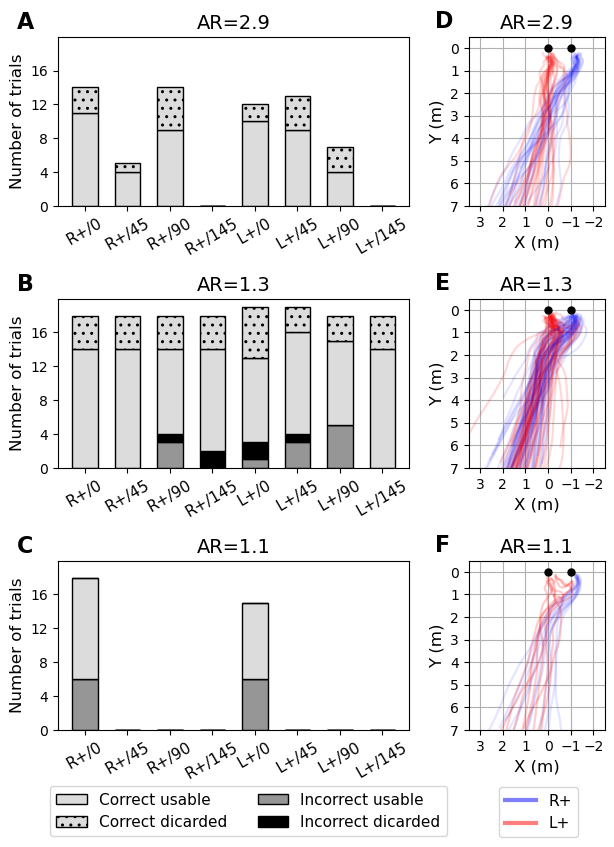

In [30]:
fig = plt.figure(figsize=(7, 9), facecolor="w")

gs = fig.add_gridspec(3, 3)

plt.subplots_adjust(hspace=0.55)


# Trial counts
ax_L_cnt = fig.add_subplot(gs[0, :2])
ax_M_cnt = fig.add_subplot(gs[1, :2])
ax_S_cnt = fig.add_subplot(gs[2, :2])

for axx, sph_str, title_str, panel in zip(
    [ax_L_cnt, ax_M_cnt, ax_S_cnt], ["L", "M", "S"], ["AR=2.9", "AR=1.3", "AR=1.1"], ["A", "B", "C"]
):
    for seq, tca in enumerate(TARGET_ANGLE_STR):
        # Tally trials
        s_executed = df_main.loc[
            (df_main["TARGET_ANGLE"]==tca) & (df_main["SPHEROID"]==sph_str), "CHOICE"
        ].value_counts()
        s_usable = df_main.loc[
            (df_main["TARGET_ANGLE"]==tca)
            & (df_main["SPHEROID"]==sph_str)
            & df_main["trial_usable_combine"],  # usable trial from 2 criteria
            "CHOICE"
        ].value_counts()
        
        # Add index to series if no trials
        for s in [s_executed, s_usable, ]:
            if not 0 in s.index or np.isnan(s[0]):
                s[0] = 0
            if not 1 in s.index or np.isnan(s[1]):
                s[1] = 0
        s_not_usable = s_executed - s_usable
        
        # 0-wrong, 1-correct
        bar_stack_sequence = np.array(
            [s_usable[0], s_not_usable[0], s_usable[1], s_not_usable[1]]
        )
        stack_height = np.hstack((0, np.cumsum(bar_stack_sequence)))[:-1]

        for bar_height, bar_bottom, bar_hatch, bar_color in zip(
            bar_stack_sequence, stack_height, hatch_seq, color_seq
        ):
            axx.bar(
                seq, bar_height, bottom=bar_bottom, color=bar_color, hatch=bar_hatch, width=barwidth, edgecolor="k"
            )
        
    axx.set_xticks(np.arange(8))
    axx.set_xticklabels(TARGET_ANGLE_STR_NEW, fontsize=11, rotation=30)
    axx.set_yticks(np.arange(0, 19, 4))
    axx.set_yticklabels(np.arange(0, 19, 4), fontsize=10)
    axx.set_ylabel("Number of trials", fontsize=12)
    axx.set_xlim(-0.63, 7.63)
    axx.set_title(title_str, fontsize=14)
    axx.set_ylim(0, 20)
    axx.text(-1.6, 21, panel, fontsize=16, fontweight="bold")

    
# Make legend
plt.bar(np.nan, np.nan, color=correct_usable[0], hatch=correct_usable[1],
        edgecolor="k", label="Correct usable")
plt.bar(np.nan, np.nan, color=correct_discard[0], hatch=correct_discard[1],
        edgecolor="k", label="Correct dicarded")
plt.bar(np.nan, np.nan, color=incorrect_usable[0], hatch=incorrect_usable[1],
        edgecolor="k", label="Incorrect usable")
plt.bar(np.nan, np.nan, color=incorrect_discard[0], hatch=incorrect_discard[1],
        edgecolor="k", label="Incorrect dicarded")

plt.legend(
    bbox_to_anchor=(-1, -13.5), bbox_transform=ax_S_cnt.transData,
    ncol=2, fontsize=11, loc="lower left"
)



# Trial tracks
# ===================================
ax_L_trk = fig.add_subplot(gs[0, 2])
ax_M_trk = fig.add_subplot(gs[1, 2])
ax_S_trk = fig.add_subplot(gs[2, 2])
# ===================================
for sph_n, sph_ax, sph_str, panel in zip(
    ["L", "M", "S"],
    [ax_L_trk, ax_M_trk, ax_S_trk],
    ["AR=2.9", "AR=1.3", "AR=1.1"],
    ["D", "E", "F"]
):
    df_sel = df_main[
        (df_main["SPHEROID"]==sph_n)
        & (df_main["CHOICE"]==1)
        & df_main["trial_usable_combine"]
    ]
    line_alpha_TC = 0.1 if sph_n != "S" else 0.1
    line_alpha_CT = 0.15 if sph_n != "S" else 0.2
    for trial_idx in df_sel.index:
        df_track = df_track_all[trial_idx]
        if df_track is not None:
            if df_main.loc[trial_idx]["TARGET_ANGLE"][:2] == "TC":
                plot_track(sph_ax, df_track, color="b", alpha=line_alpha_TC, lw=1.6)
            else:
                plot_track(sph_ax, df_track, color="r", alpha=line_alpha_CT, lw=1.6)
    sph_ax.plot(0, 0, marker="o", markersize=5, color="k")
    sph_ax.plot(-1, 0, marker="o", markersize=5, color="k")
    sph_ax.set_title(sph_str, fontsize=14)
    sph_ax.text(5, -0.9, panel, fontsize=16, fontweight="bold")

# Shrink panel width
for axx in [ax_L_trk, ax_M_trk, ax_S_trk]:
    axx_pos = axx.get_position()
    axx.set_position([
        axx_pos.x0+0.04, axx_pos.y0, axx_pos.width*0.85, axx_pos.height
    ])


for axx in [ax_L_trk, ax_M_trk, ax_S_trk]:
    axx.invert_yaxis()
    axx.grid()
    axx.set_xlabel("X (m)", fontsize=12)
    axx.set_ylabel("Y (m)", fontsize=12)
    axx.set_yticks(np.arange(9))
    axx.set_xticks(np.arange(-2, 3.5, 1))
    axx.set_ylim(7, -0.5)
    axx.set_xlim(3.5, -2.5)

    
plt.plot(np.nan, np.nan, color="b", label="R+", alpha=0.5, lw=3)
plt.plot(np.nan, np.nan, color="r", label="L+", alpha=0.5, lw=3)

plt.legend(
    bbox_to_anchor=(2.5, 12.1), bbox_transform=ax_S_trk.transData,
    ncol=1, fontsize=11, loc="lower left"
)




plt.show()

fig.savefig(fig_path / "fig_trial_counts_track.png", dpi=150, bbox_inches="tight")